# Face Mask Detection

> During pandemic COVID-19, WHO has made wearing masks compulsory to protect against this deadly virus. In this project we will develop a machine learning/ Deep Learning project – Real-time Face Mask Detector with Python.

## Import Libraries

In [50]:
import os, logging
import itertools
import shutil
from glob import glob
import random
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from keras.applications.resnet50 import decode_predictions
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Flatten, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

## Configure Physical Device(s)  

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPUs: {len(physical_devices)}")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Number of GPUs: 1


## Connect storage & Retrive the dataset

In [ ]:
# Direct the dataset into our workshop
mainFold = "/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Face_Mask_Detection"
os.chdir(mainFold)

In [ ]:
# Download the dataset
!wget https://data-flair.s3.ap-south-1.amazonaws.com/Data-Science-Data/face-mask-dataset.zip

--2021-08-06 00:30:23--  https://data-flair.s3.ap-south-1.amazonaws.com/Data-Science-Data/face-mask-dataset.zip
Resolving data-flair.s3.ap-south-1.amazonaws.com (data-flair.s3.ap-south-1.amazonaws.com)... 52.219.158.62
Connecting to data-flair.s3.ap-south-1.amazonaws.com (data-flair.s3.ap-south-1.amazonaws.com)|52.219.158.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76808601 (73M) [application/zip]
Saving to: ‘face-mask-dataset.zip’

face-mask-dataset.z 100%[===================>]  73.25M  7.85MB/s    in 11s     

2021-08-06 00:30:35 (6.46 MB/s) - ‘face-mask-dataset.zip’ saved [76808601/76808601]



In [ ]:
!unzip face-mask-dataset.zip

Archive:  face-mask-dataset.zip
  inflating: Dataset/test.zip        
  inflating: Dataset/train.zip       


In [ ]:
os.chdir('Dataset')

In [ ]:
!unzip train.zip
!unzip test.zip

In [ ]:
!rm -rf train.zip test.zip

## Image Preprocessing

Let's specify the directory of our dataset

In [3]:
mainFold = "/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Face_Mask_Detection/Dataset"
os.chdir(mainFold)

In [ ]:
# Create a validation folders
if os.path.isdir('valid/with_mask/') is False:
  # Creating folders dir
  os.mkdir('valid')
  os.mkdir('valid/with_mask')
  os.mkdir('valid/without_mask')

  # get random samples for adding it into with_mask validation folder
  no_with_mask = random.sample(glob('train/with_mask/*.jpg'), round(len(glob('train/with_mask/*.jpg')) * 0.1))
  for image in no_with_mask:
    shutil.move(image, 'valid/with_mask')
  
  print('Validation Mask is Ready!')
  # get random samples for adding it into without_mask validation folder
  no_without_mask = random.sample(glob('train/without_mask/*.jpg'), round(len(glob('train/without_mask/*.jpg')) * 0.1))
  for image in no_without_mask:
    shutil.move(image, 'valid/without_mask')

  print('Validation without Mask is Ready!')

Validation Mask is Ready!
Validation without Mask is Ready!


In [4]:
# Check the validation folders
print(len(glob("valid/with_mask/*.jpg")))
print(len(glob("valid/without_mask/*.jpg")))

65
64


## Train, Validation, and Test

Now, we will normalize our image dataset, so we can use it in our model.

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
                .flow_from_directory('train', target_size=(224,224), batch_size=10, classes = ['with_mask', 'without_mask'])
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
                .flow_from_directory('valid', target_size=(224,224), batch_size=10, classes = ['with_mask', 'without_mask'])
test_batches  = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
                .flow_from_directory('test', target_size=(224,224), batch_size=10, classes= ['with_mask', 'without_mask'], shuffle=False)

Found 1186 images belonging to 2 classes.
Found 129 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


In [6]:
# Let's ensure that everything goes well, by validating our normalized dataset
assert train_batches.n == 1315 - valid_batches.n
assert valid_batches.n == (65+64)
assert test_batches.n == 97 + 97

## Algorithm Setup

In [7]:
resModel = tf.keras.applications.ResNet50()

102973440/102967424 [==============================] - 1s 0us/step


In [8]:
type(resModel)

tensorflow.python.keras.engine.functional.Functional

In [9]:
resModel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

We're going to remove the last layer from our model and insert a new layer with respect to 2 classes [with_mask, without_mask]

In [55]:
x = resModel.layers[-2].output
output = Dense(units=2, activation='softmax')(x)

We're going to freeze all the layers to keep the weights and bias without changing them while we're training our images [with_mask, without_mask]

In [56]:
model = Model(inputs=resModel.input, outputs=output)

In [57]:
for layer in model.layers[:-2]:
  layer.trainable = False

In [58]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

## Fit Model

Initialize a callback checkpoint to keep saving the best model after each epoch while training.

In [59]:
checkpoint = ModelCheckpoint('model2-{epoch:03d}.model',save_best_only=True, mode='auto')

In [60]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
H = model.fit(x=train_batches, validation_data=valid_batches, epochs=5,callbacks=checkpoint, verbose=2)

Epoch 1/5
119/119 - 20s - loss: 0.5266 - accuracy: 0.8137 - val_loss: 0.3326 - val_accuracy: 0.9535


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
119/119 - 15s - loss: 0.2471 - accuracy: 0.9806 - val_loss: 0.1874 - val_accuracy: 0.9922


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/5
119/119 - 15s - loss: 0.1479 - accuracy: 0.9907 - val_loss: 0.1268 - val_accuracy: 0.9922


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/5
119/119 - 15s - loss: 0.1029 - accuracy: 0.9916 - val_loss: 0.0951 - val_accuracy: 0.9922


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/5
119/119 - 15s - loss: 0.0782 - accuracy: 0.9933 - val_loss: 0.0748 - val_accuracy: 0.9922


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Fitting Model accuracy Visualization

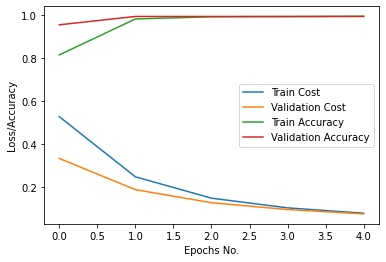

In [70]:
plt.figure()
plt.plot(np.arange(0, 5), H.history['loss'], label='Train Cost')
plt.plot(np.arange(0, 5), H.history['val_loss'], label='Validation Cost')
plt.plot(np.arange(0, 5), H.history['accuracy'], label='Train Accuracy')
plt.plot(np.arange(0, 5), H.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs No.")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('Fit model Accuracy_loss')
plt.show()

## Predict Model

In [73]:
pred = model.predict(test_batches, verbose=0)

## Model Evaluation

In [72]:
y_true = test_batches.classes

In [76]:
f1_score(y_true=y_true, y_pred=np.argmax(pred, axis=-1))

0.9896907216494846

### Predicted model Visualization

In [77]:
cm = confusion_matrix(y_true=y_true, y_pred=np.argmax(pred, -1))

In [90]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[96  1]
 [ 1 96]]


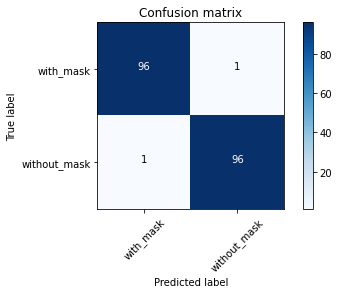

In [91]:
plot_confusion_matrix(cm, classes=['with_mask', 'without_mask'])

## Export Model

In [92]:
if os.path.isfile('Model/mask_detection.h5') is False:
  os.mkdir("Model")
  model.save('Model/mask_detection.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Test Model

First, we need to create a function to pre-processing the input images,

In [127]:
def img_preprocessing(file: str) -> tf.keras.applications.resnet50.preprocess_input:
    """
    This function is preparing the input image by:
        1. Loading the image into the function and re-sizing it to (224,224) input processing size.
        2. Convert the image into an array – so, the application would be able to proccess the image.
        3. Start to expand the dimension of the image –this will help to put the image into dimension that ResNet expects.
        4. Return a preprocess input of ResNet which converting the image from RGB to BGR. Then get the average of colors' channel in the image.
    """
    img_path='Dataset/RW_test_imgs/'
    load_img = image.load_img(img_path + file, target_size=(224,224))
    img_array = image.img_to_array(load_img)
    img_expand_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.resnet50.preprocess_input(img_expand_dims)


In [136]:
def pred_classes(preprocessed_img, classes=list) -> str:
    """
    This function helps to return a string class name instead of returning proability of the classes.
    """
    return f" {model.predict(preprocess_image)} -> {classes[model.predict(preprocess_image).argmax()]}" 

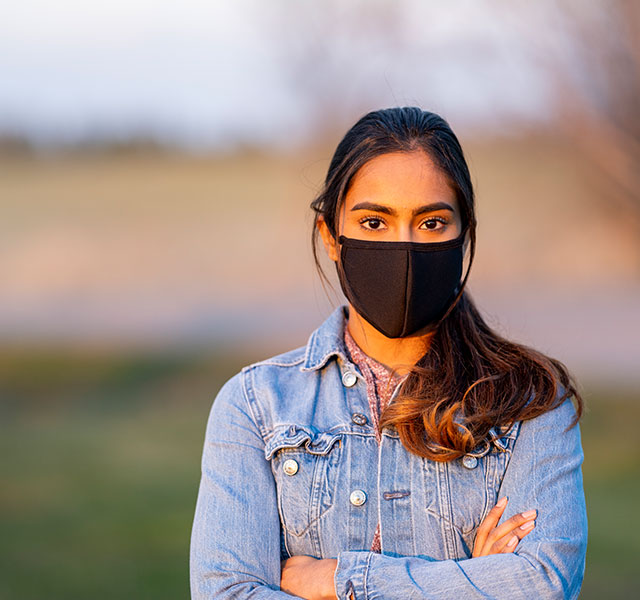

In [139]:
# Load image
from IPython.display import Image
Image(filename='Dataset/RW_test_imgs/mask03.jpg', width=300, height=200)

In [30]:
model = load_model("Model/mask_detection.h5")

In [145]:
preprocess_image = img_preprocessing("mask03.jpg")
classes = ['Mask', 'No Mask']
classes[model.predict(preprocess_image).argmax(1)

TypeError: only integer scalar arrays can be converted to a scalar index

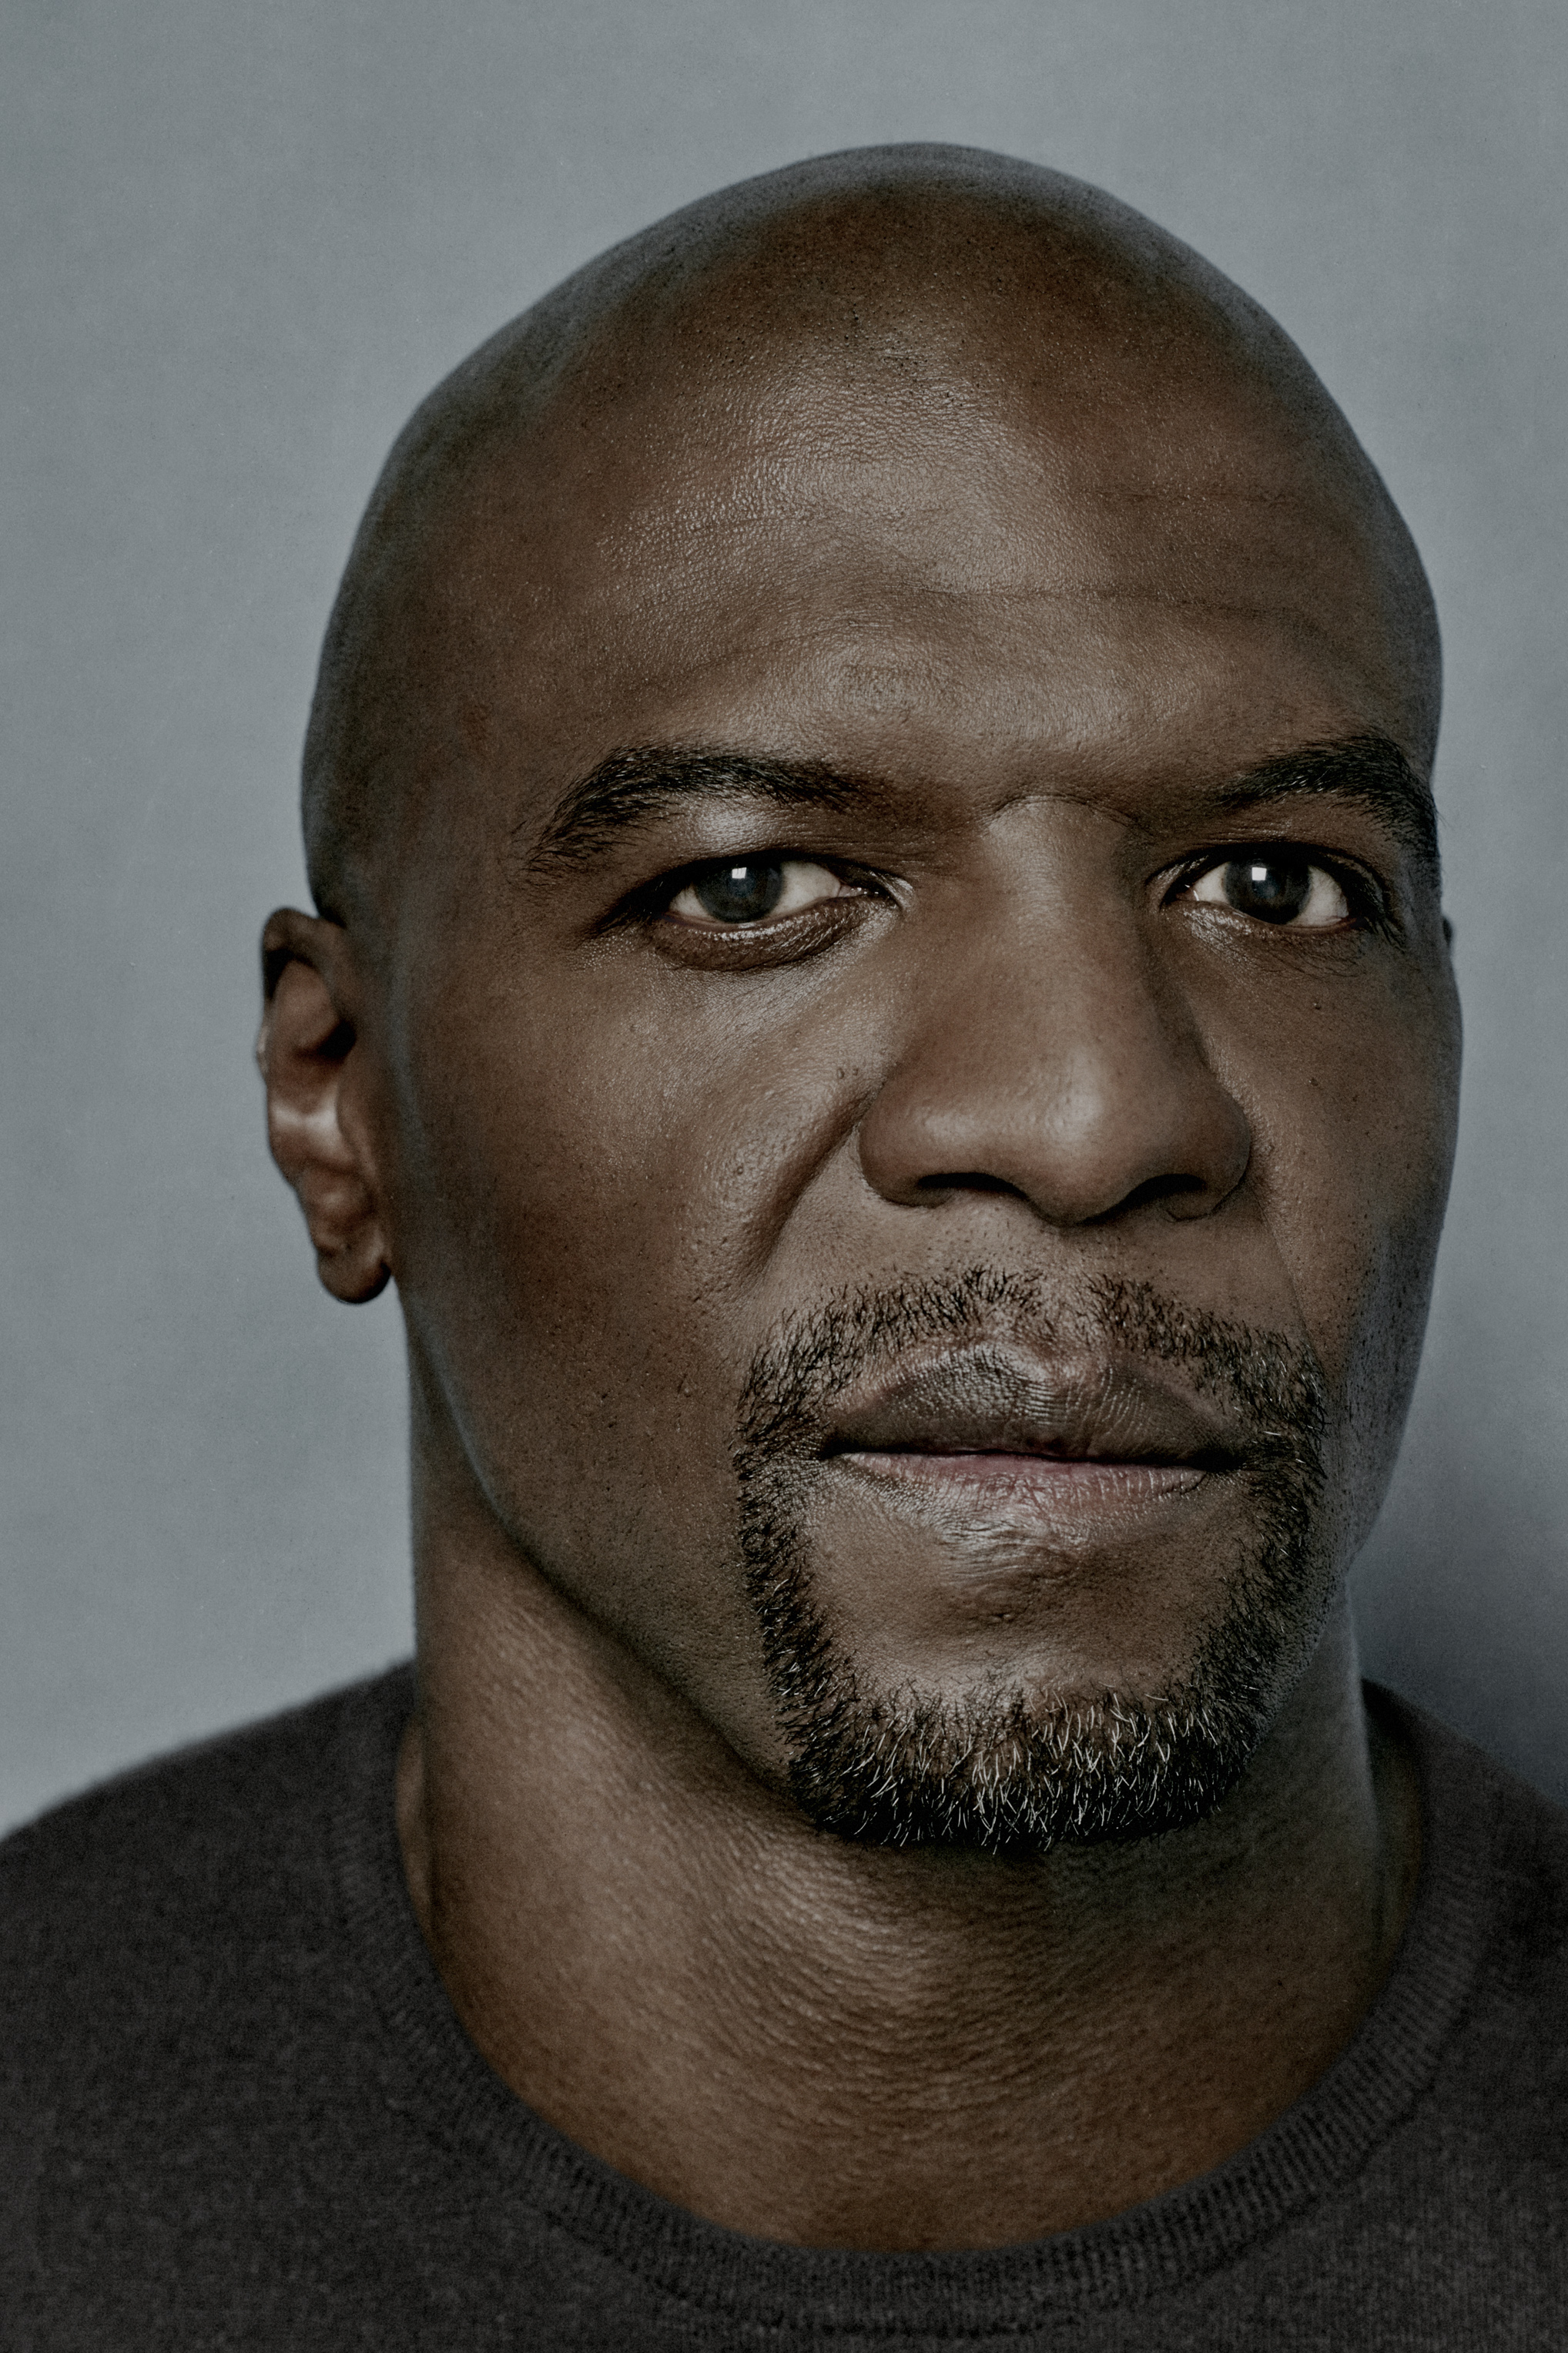

In [143]:
Image(filename='Dataset/RW_test_imgs/without_mask02.jpg', width=30, height=20)

In [144]:
preprocess_image = img_preprocessing("without_mask02.jpg")
classes = ['Mask', 'No Mask']
pred_classes(preprocess_image, classes)

' [[2.1262611e-05 9.9997878e-01]] -> No Mask'